In [1]:
import keras
keras.__version__

'2.7.0'

In [2]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from tensorflow.python.framework import ops
import keras.backend as K
from PIL import Image
import tensorflow as tf
import numpy as np
import keras
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display as display
from IPython.display import Image
import os
tf.compat.v1.disable_eager_execution()

In [3]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [4]:
def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [5]:
def grad_cam(model, x, category_index, layer_name):
    """
    Args:
       model: model
       x: image input
       category_index: category index
       layer_name: last convolution layer name
    """
    # get category loss
    class_output = model.output[:, category_index]

    # layer output
    convolution_output = model.get_layer(layer_name).output
    # get gradients
    grads = K.gradients(class_output, convolution_output)[0]
    # get convolution output and gradients for input
    gradient_function = K.function([model.input], [convolution_output, grads])

    output, grads_val = gradient_function([x])
    output, grads_val = output[0], grads_val[0]

    # avg
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # create heat map
    cam = cv2.resize(cam, (x.shape[1], x.shape[2]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    # Return to BGR [0..255] from the preprocessed image
    image_rgb = x[0, :]
    image_rgb -= np.min(image_rgb)
    image_rgb = np.minimum(image_rgb, 255)

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image_rgb)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [6]:
pic_folder = "./img/"
pic_cam_folder = "./img_grad_cam/"
model_vgg = VGG16(weights='imagenet')
print(model_vgg.summary())
list_name = os.listdir(pic_folder)

arr_images = []
for i, file_name in enumerate(list_name):
    img = load_image(pic_folder + file_name)
    predictions = model_vgg.predict(img)
    top_1 = decode_predictions(predictions)[0][0]
    print('Predicted class:')
    print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

    predicted_class = np.argmax(predictions)
    cam_image, heat_map = grad_cam(model_vgg, img, predicted_class, "block5_pool")

    img_file = image.load_img(pic_folder + list_name[i])
    img_file = image.img_to_array(img_file)

    # save img
    cam_image = cv2.resize(cam_image, (img_file.shape[1], img_file.shape[0]), cv2.INTER_LINEAR)
    cv2.putText(cam_image,str(top_1[1]), (20, 20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1,(0, 0, 255))
    cv2.putText(cam_image,str(top_1[2]), (20, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1,(0, 0, 255))

    cam_image = cam_image.astype('float32')
    im_h = cv2.hconcat([img_file, cam_image])
    cv2.imwrite(pic_cam_folder + list_name[i], im_h)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Predicted class:
garbage_truck (n03417042) with probability 0.15
Predicted class:
fur_coat (n03404251) with probability 0.19
Predicted class:
boxer (n02108089) with probability 0.42
Predicted class:
cab (n02930766) with probability 0.63
Predicted class:
boxer (n02108089) with probability 0.42
Predicted class:
shovel (n04208210) with probability 0.09
Predicted class:
motor_scooter (n03791053) with probability 0.27
Predicted class:
lab_coat (n03630383) with probability 0.77
Predicted class:
cab (n02930766) with probability 0.14
Predicted class:
lion (n02129165) with probability 0.83
Predicted class:
wig (n04584207) with probability 0.35
Predicted class:
sorrel (n02389026) with probability 0.90
Predicted class:
French_bulldog (n02108915) with probability 0.89
Predicted class:
bullet_train (n02917067) with probability 0.98
Predicted class:
malinois (n02105162) with probability 0.76
Predicted class:
Great_Pyrenees (n02111500) with probability 0.73
Predicted class:
pug (n02110958) with proba

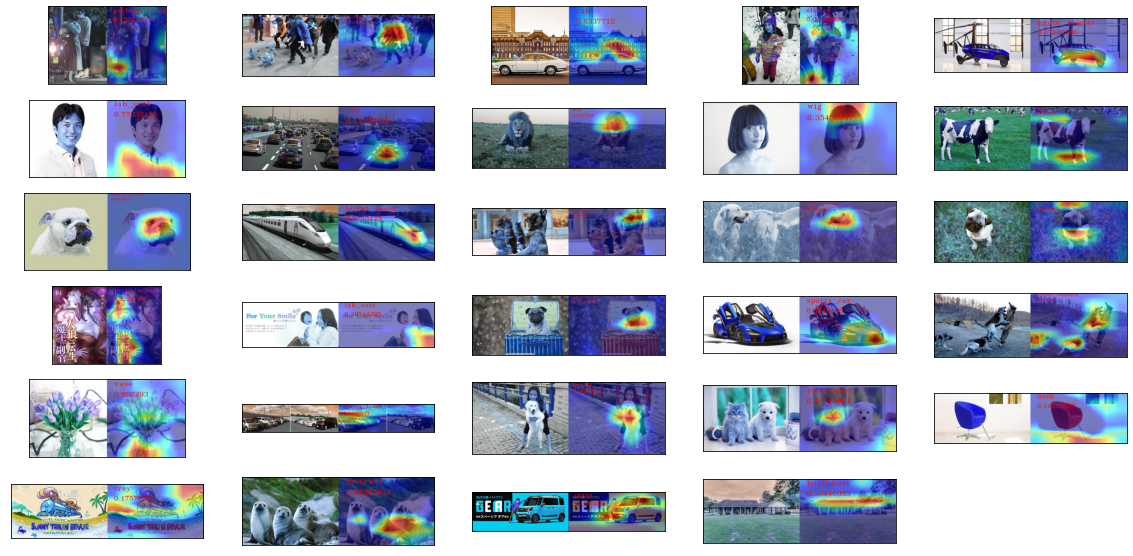

In [7]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('./img_grad_cam/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])